In [42]:
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem import PorterStemmer
from sklearn.model_selection import KFold
import re

In [43]:
class TweetCleaner():
    def __init__(self):
        pass


    def _scrub_words(self, text):
        # remove html markup
        text=re.sub("(<.*?>)","",text)
    
        #remove non-ascii and digits
        text=re.sub("(\\W|\\d)"," ",text)
  
        #remove whitespace
        text=text.strip()
        return text
  
    #Noise removal, stop word removal, normalizing?
    def _cleanString(self, s, special_chars = "\":,.|#ðÿœžðÿâœœïÿœžÿºÿÿœžÿ"):
        #remove hyperlinks and twitter usernames
        web_regex =  r"(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))"
        s = re.sub('(?<!\w)@[\w+]{1,15}', '', s)
        s = re.sub(web_regex, '', s)
        
        for char in special_chars:
            s = s.replace(char, "")
            s = s.replace("\n", "")
            s = self._scrub_words(s)

        tokenizer = TweetTokenizer()
        stop_words = set(stopwords.words('english'))
        cleaned_words = [w for w in tokenizer.tokenize(s) if w not in stop_words]
        
        return " ".join(cleaned_words)

    def _stemWords(self, sentence):
        stemmer, tokenizer = PorterStemmer(), TweetTokenizer()
        stemmed_words = [stemmer.stem(w) for w in tokenizer.tokenize(sentence)]
        return " ".join(stemmed_words)
    
    def cleanFrame(self, frame):
        frame['clean_paper'] = frame.comment_text.apply(self._cleanString)

    def stemFrame(self, frame):
        frame['stem_paper'] = frame.clean_paper.apply(self._stemWords)

    
    def rebrand_senti(self, senti):
        if senti != 0:
            senti = 1
        return senti

        
    def wordTokenize(self, sentence):
        """
        This function performs word tokenization using regular expressions.
        """
        regex = "[a-zA-Z]+" #this is another form to split the sentences into words by using regular expressions
        tokenized = re.findall(regex, sentence) #it finds all the matching cases of the regex in the string text and it return a list of words
        return tokenized

In [44]:
df = pd.read_csv('train.csv')
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


# EDA

In [45]:
df.toxic.unique()

array([0, 1])

In [46]:
df.toxic.value_counts()

0    144277
1     15294
Name: toxic, dtype: int64

In [47]:
pos = df[df.toxic==0]
neg = df[df.toxic==1]

size = neg.shape[0]

In [48]:
pos_bal = pos.sample(len(neg))
len(pos_bal)

15294

In [49]:
pos_bal.toxic.unique()

array([0])

In [50]:
df = pd.concat([pos_bal, neg])
df.reset_index(drop=True, inplace=True)
df

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,3e7535facaf4d4ca,The last RFC ended with no consensus and since...,0,0,0,0,0,0
1,d0a8fdb00366e43d,"""\n\n Your links at Fatal Frame \n\nI saw your...",0,0,0,0,0,0
2,0872772b0919629e,"""\n\nWhat\nHow exactly was my edit to """"Lil Jo...",0,0,0,0,0,0
3,341a65d50ccc9861,"""This comment is a classic straw man argument ...",0,0,0,0,0,0
4,c48864479ab0d6cf,Be prepared for HORRIBLE HORRIBLE THINGS!!!,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
30583,fef4cf7ba0012866,"""\n\n our previous conversation \n\nyou fuckin...",1,0,1,0,1,1
30584,ff39a2895fc3b40e,YOU ARE A MISCHIEVIOUS PUBIC HAIR,1,0,0,0,1,0
30585,ffa33d3122b599d6,Your absurd edits \n\nYour absurd edits on gre...,1,0,1,0,1,0
30586,ffb47123b2d82762,"""\n\nHey listen don't you ever!!!! Delete my e...",1,0,0,0,1,0


0    15294
1    15294
Name: toxic, dtype: int64


/home/ulises/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


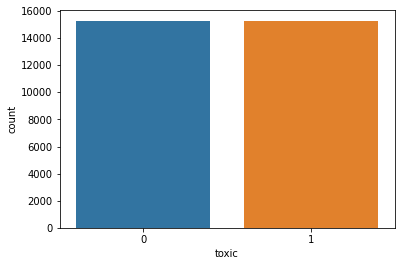

In [52]:
#Balancing the data to solve undersampling
print(df.toxic.value_counts())
sns.countplot(df.toxic)
plt.show()

In [10]:
df.toxic.value_counts()

0    15294
1    15294
Name: toxic, dtype: int64

In [11]:
labelScore = list(df.sum(axis = 1, skipna = True))
newLabelScore = [1 if (x>0) else 0 for x in labelScore]

/tmp/ipykernel_11842/2826411018.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  labelScore = list(df.sum(axis = 1, skipna = True))


In [12]:
df['Toxic'] = newLabelScore
labelColumns=['toxic','severe_toxic','obscene','threat','insult','identity_hate','id']
data = df.drop(columns=labelColumns)

In [13]:
data.head()

,comment_text,Toxic
0,"Hey, I failed to notice this message previousl...",0
1,""":::Please dont keep leaving your useless tral...",0
2,"""\n\nSlash """"/"""" and backslash """"\"""" are the h...",0
3,"""\nMaybe there's a better way to do it... Not ...",0
4,"""\n\nThank you for your view. However, could ...",0


In [14]:
class PreProcessor:
    
    def __init__(self, noise_chars):
        self.noise_chars = noise_chars #declare the noisy characters, we do not use @ or # as we need them for regex extraction
    
    def removeNoise(self, string):
        """
        This function removes noise from the text by lowering cases, removing character entities
        references, removing links, and removing given noisy characters.
        """
        string = string.lower() #converts the text to lower case 
        string = re.sub('&[a-zA-Z]+;', '', string) #remove character entities reference
        string = re.sub('http\S+', '', string)#remove links
        string = re.sub('www\S+', '', string)
        string = re.sub("\\xa0·", " ", string)
        string = re.sub("(UTC)", " ", string)
        string = re.sub('^b\s+', '', string)
        string = re.sub('@[A-Za-z0-9]+', '', string)
        string = re.sub("â€\x9d&lt;", "", string)
        string = re.sub("â€œ:", "", string)
        string = re.sub('pleas', 'please', string)
        string = re.sub('dont', 'do not', string)
        for char in self.noise_chars:
            string = string.replace(char, '') #removes any noisy character from the list noise_chars
        cleaned = string #the cleaned string is passed and returned
        return cleaned
    
    def removeStopwords(self, string):
        """
        This function removes stopwords from the text. It uses a corpus of stopwords from NLTK and they 
        can be extended.
        """
        words = []
        for i in string.split(" "):#split the text into spaces so it is divided into words
            words.append(i) #each word is appended in the list of words
        stop_words = stopwords.words('english') #the stopwords corpus provided by NLTK is used for remove them
        stop_words.extend(['that','thats','oh', 'aww', 'mr', 'r', 'what', 'etc', 'hey', 'within', 'foi', 'yeah', 'www', 'wa', 'em', 'am', 'i', 'me', 'dialmformurderjpg' ]) #we can extend the list of stopwords in this line
        cleaned = [w for w in words if w not in stop_words] #each word in the list of words is checked for stopwords in the corpus
        cleaned_stopwords = " ".join(cleaned)
        return cleaned_stopwords
    
    def textNormalization(self, string):
        """
        This function normalizes text by reducing length of letters in words and correcting spelling of words.
        """
        normalized = []
        tokenizer = nltk.tokenize.TweetTokenizer() #we use the TweetTokenizer to reduce length of letters in the words
        len_reduced = tokenizer.tokenize(string) #the function is applied to the text returning the length reduced
        for word in len_reduced:
            check_spell = TextBlob(word) #we use TextBlob spelling checking as the minimum lenght applied by TweetTokenizer is three letters and there can be some mispelled words
            normalized.append(str(check_spell.correct())) #it is returned the correct spell of the word and appended to normalized list of words
        normalized = " ".join(normalized)
        return normalized
    
    def stemWords(self, string):
        """
        This function performs stemming of words by chopping off inlfections of words using Port Stemmer algorithm.
        Also it corrects mispelling of words.
        """
        words = []
        stemmed = []
        for i in string.split(" "):
            words.append(i)
        stemmer = PorterStemmer() #it is used PorterStemmer to reducing inflection of words to their original word form
        stemmed_words = [stemmer.stem(w) for w in words] #it is applied to each word
        for word in stemmed_words:
            check_spell = TextBlob(word) #again, we use spelling checking as some words might result mispelled or not complete
            stemmed.append(str(check_spell.correct()))
        stemmed = " ".join(stemmed)
        return stemmed
    
    def lemmatizeWords(self, string):
        """
        This function performs word lemmatization by transforming inflections of words in their root form using
        WordNetLemmatization from NLTK. Also it checks mispelling of words.
        """
        words = []
        lemmatized = []
        for i in string.split(" "):
            words.append(i)
        lemmatizer = WordNetLemmatizer() #it is used WordNetLemmatizer to transform word inflections to root form. It is similar to stemming but it does not just chop off words.
        lemmatized_words = [lemmatizer.lemmatize(w) for w in words] #it is applied to each word
        for word in lemmatized_words:
            check_spell = TextBlob(word) #again, we use spelling checking as some words might result mispelled or not complete
            lemmatized.append(str(check_spell.correct()))
        lemmatized = " ".join(lemmatized)
        return lemmatized
    
    def wordTokenize(self, string):
        """
        This function performs word tokenization using regular expressions.
        """
        regex = "[a-zA-Z]+" #this is another form to split the sentences into words by using regular expressions
        tokenized = re.findall(regex, string) #it finds all the matching cases of the regex in the string text and it return a list of words
        return tokenized

    
    def process(self, string):
        """
        This function summarizes and apply all the preprocessing tasks.
        """
        cleaned = self.removeNoise(string)
        cleaned_stopwords = self.removeStopwords(cleaned)
        normalized = self.textNormalization(cleaned_stopwords)
        stemmed = self.stemWords(normalized)
        #lemmatized = self.lemmatizeWords(normalized)
        tokenized = " ".join(self.wordTokenize(stemmed))
        cleaned = self.removeNoise(tokenized)
        preprocessed = self.removeStopwords(cleaned)
        return preprocessed

In [15]:
class Classifier:

  def __init__(self, pre_processor = None, max_features=20000, maxlen=100):
    self.preProcessor = pre_processor if pre_processor else PreProcessor("#@,.?!¬-\''=()") #this calls the PreProcessor class
    self.max_features = max_features
    self.maxlen = maxlen

  def prepare_data(self, X):
    """
    This function prepares the data by performing preprocessing and vectorization.
    """
    try: #try if the data is more than 1 record
      preprocessed = []
      for comment in X:
          preprocessed.append(self.preProcessor.process(comment))
      pickle.dump(preprocessed, open('preprocessed_data.pickle','wb')) #save preprocessed comments in a pickle file
      data_prepared = self.vectorize(preprocessed)
    except: #do if it is only 1 record
      preprocessed = self.preProcessor.process(X)
      data_prepared = self.vectorize(preprocessed)

    return data_prepared

  def get_model(self):
    """
    A Keras model consists of:
    An architecture, or configuration, which specifies what layers the model contain, and how they're connected.
    A set of weights values (the "state of the model").
    An optimizer state (defined by compiling the model).
    A set of losses and metrics (defined by compiling the model).
    """
    #define the architecture of the neural network
    embed_size = 128
    inp = Input(shape=(self.maxlen, )) #input layer
    x = Embedding(self.max_features, embed_size)(inp) #useful for NLP tasks
    x = Bidirectional(LSTM(50, return_sequences=True))(x) #50 neurons; bidirectional used for give information backwards
    x = GlobalMaxPool1D()(x) #to get highest activation of the previous layer
    x = Dropout(0.1)(x) #Regularization strategy
    x = Dense(50, activation="relu")(x) #fully connected  
    x = Dropout(0.1)(x)
    x = Dense(1, activation="sigmoid")(x) #1 neuron for only one class (toxic or non-toxic), change according to the number of classes 
    model = Model(inputs=inp, outputs=x)
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

  def vectorize(self, X):
    """
    This function vectorizes the preprocessed data.
    """
    list_sentences = X
    tokenizer = text.Tokenizer(num_words=self.max_features)
    tokenizer.fit_on_texts(list(list_sentences))
    list_tokenized = tokenizer.texts_to_sequences(list_sentences) #receive text and return a sequence (indexes of the words)
    X_vector = sequence.pad_sequences(list_tokenized, maxlen=self.maxlen) #pads with zeros to fulfill the maxlen if not reached
    
    return X_vector

  def fit(self, X, y, batch_size=32, epochs=2):
    """
    This function performs the training of the model.
    It also saves the model in a given location with the best weightss.
    """
    #self.X_vector = self.prepare_data(X)
    self.X_vector = X
    model = self.get_model()
    self.batch_size = batch_size #number of samples of the network in order to estimate the gradient
    self.epochs = epochs

    #Defining the callbacks
    file_path="weights_base.best.hdf5"
    checkpoint = ModelCheckpoint(file_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min') #after each epoch, saves the best weights of the best neural network

    early = EarlyStopping(monitor="val_loss", mode="min", patience=20) #monitors if validation loss is getting worse, it stops

    callbacks_list = [checkpoint, early]
    history = model.fit(self.X_vector, y, batch_size=self.batch_size, epochs=self.epochs, validation_split=0.1, callbacks=callbacks_list)

    model.load_weights(file_path)
    model.save('./drive/MyDrive/classificationModel_compiled')

    return history


  def predict(self, X):
    """
    This function performs prediction of data by loading a saved model.
    """
    #X_vector = self.prepare_data(X)
    X_vector = X
    self.model = load_model('./drive/MyDrive/classificationModel_compiled')
    return self.model.predict(X_vector)

  def summarize(self):
    """
    This model summirizes the model.
    """
    model = self.get_model()
    model.summary()

  def evaluate(self, X, y):
    #X_vector = self.prepare_data(X)
    X_vector = X
    self.model = load_model('./drive/MyDrive/classificationModel_compiled')
    loss, acc = self.model.evaluate(X_vector, y, verbose=2)
    print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

  def plot_history(self, history):
    """
    This function plots both accuracy and loss history during epochs of the training process.
    """
    # summarize history for accuracy
    self.history = history
    plt.plot(self.history.history['accuracy'])
    plt.plot(self.history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(self.history.history['loss'])
    plt.plot(self.history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

  def plot_model(self):
    """
    This function saves a plot of the model.
    """
    plot_model(self.get_model())

In [16]:
classifier = Classifier()

In [17]:
from itertools import product
import random
import pickle
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem import PorterStemmer, WordNetLemmatizer
from textblob import TextBlob 
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import Dense, Embedding, Input
from keras.layers import LSTM, Bidirectional, GlobalMaxPool1D, Dropout
from keras.preprocessing import text, sequence
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils.vis_utils import plot_model
from keras.models import load_model
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt

2021-12-03 12:40:34.491364: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-03 12:40:34.491445: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [18]:
X = df["comment_text"].fillna("NODATA").values
y = df['toxic'].values

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
X_vectorized = classifier.vectorize(X_train)

In [21]:
history = classifier.fit(X_vectorized, y_train, epochs=2)

2021-12-03 12:41:00.728479: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-12-03 12:41:00.728554: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-12-03 12:41:00.728615: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ulises-Lenovo-ideapad-320-15IKB): /proc/driver/nvidia/version does not exist
2021-12-03 12:41:00.729262: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-03 12:41:02.264459: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185]

Epoch 1/2
689/689 [==============================] - 64s 87ms/step - loss: 0.2976 - accuracy: 0.8689 - val_loss: 0.2262 - val_accuracy: 0.9056

Epoch 00001: val_loss improved from inf to 0.22616, saving model to weights_base.best.hdf5
Epoch 2/2
689/689 [==============================] - 60s 87ms/step - loss: 0.1433 - accuracy: 0.9457 - val_loss: 0.2567 - val_accuracy: 0.8991

Epoch 00002: val_loss did not improve from 0.22616


2021-12-03 12:43:12.014627: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./drive/MyDrive/classificationModel_compiled/assets


INFO:tensorflow:Assets written to: ./drive/MyDrive/classificationModel_compiled/assets


# Metric Evaluation

In [22]:
X_test_vectorized = classifier.vectorize(X_test)

In [23]:
predicted = classifier.predict(X_test_vectorized)

In [24]:
print(classification_report(y_test, predicted.round(), digits=4, zero_division=0))

              precision    recall  f1-score   support

           0     0.5594    0.3335    0.4179      3121
           1     0.5114    0.7264    0.6002      2997

    accuracy                         0.5260      6118
   macro avg     0.5354    0.5300    0.5091      6118
weighted avg     0.5359    0.5260    0.5072      6118



In [25]:
classifier.evaluate(X_vectorized, y_train)

765/765 - 11s - loss: 0.1410 - accuracy: 0.9471
Restored model, accuracy: 94.71%


In [26]:
classifier.summarize()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 100, 128)          2560000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100, 100)          71600     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 100)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0   

# Loss and accuracy graphics

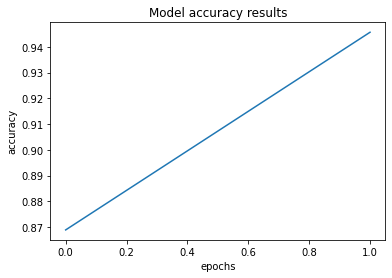

In [27]:
#Ploy the accuracy of the model in the train data
plt.plot(history.history['accuracy']) 
plt.title('Model accuracy results')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.show()

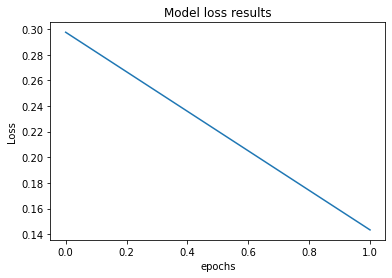

In [28]:
#Plot the loss in the train data
plt.plot(history.history['loss'])
plt.title('Model loss results')
plt.ylabel('Loss')
plt.xlabel('epochs')
plt.show()